<a href="https://colab.research.google.com/github/viguardieiro/moopt_fairness/blob/master/Sample_weight_Sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fairness by reweighing with sample_weight in Sklearn

In [1]:
import pandas as pd

mydata= pd.read_csv("/content/drive/My Drive/Vitória - TCC/Notebooks/Datasets/german_credit_data.csv")

Dados de pedidos de crédito. É um dos datasets mais utilizados para tutoriais em Fairness, como na biblioteca [$aif360$](https://github.com/IBM/AIF360/blob/master/examples/README.md). Dataset original disponível em [aqui](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)), mas eu utilizei [este](https://www.kaggle.com/kabure/german-credit-data-with-risk), por estar em formato csv com os headers, embora omita informações do dataset original.

Originalmente possui 1000 dados, mas com vários valores NaN, ficando com 522 dados após remoção de dados com informações faltantes.

In [2]:
mydata.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [3]:
mydata.shape

(1000, 11)

In [4]:
mydata = mydata.drop(['Unnamed: 0', 'Purpose'], axis=1)

In [5]:
mydata = mydata.dropna()

In [6]:
mapping_Sex = {'male': 0, 'female': 1}
mapping_Housing = {'free': 1, 'rent': 2, 'own': 3}
mapping_Savings = {'little': 1, 'moderate': 2, 'quite rich': 3, 'rich': 4}
mapping_Checking = {'little': 1, 'moderate': 2, 'rich': 3}
mapping_Risk = {"bad": -1, "good": 1}

numerical_data = mydata.replace({'Sex': mapping_Sex, 'Housing': mapping_Housing, 'Saving accounts': mapping_Savings,
                'Checking account':mapping_Checking, 'Risk': mapping_Risk})

In [7]:
numerical_data.groupby('Sex').count()

,Age,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Risk
Sex,,,,,,,,
0,354,354,354,354,354,354,354,354
1,168,168,168,168,168,168,168,168


In [8]:
numerical_data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Risk
1,22,1,2,3,1,2,5951,48,-1
3,45,0,2,1,1,1,7882,42,1
4,53,0,2,1,1,1,4870,24,-1
7,35,0,3,2,1,2,6948,36,1
9,28,0,3,3,1,2,5234,30,-1


In [9]:
X = numerical_data.drop(['Risk'], axis=1)

In [10]:
y = numerical_data['Risk']

In [11]:
X.shape

(522, 8)

In [12]:
X_test = X.iloc[:100, :]
X_train = X.iloc[100:, :]
y_test = y.iloc[:100]
y_train = y.iloc[100:]

In [13]:
X_train.shape

(422, 8)

In [14]:
X_train.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration
176,42,0,2,3,1,1,2577,12
177,52,0,2,3,3,1,338,6
179,65,0,2,3,1,1,571,21
181,30,0,3,3,1,2,4455,36
184,36,0,2,3,1,2,884,18


In [15]:
y_train.shape

(422,)

In [16]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(max_iter=1000).fit(X_train, y_train)
reg.score(X_test, y_test)

0.74

In [17]:
reg.coef_

array([[ 1.06300591e-02, -2.03097161e-01, -1.00838726e-01,
         1.26847670e-01,  2.37995428e-01,  2.60888932e-01,
         5.30973633e-06, -4.72519297e-02]])

In [18]:
!pip install sklego

     |████████████████████████████████| 204kB 3.4MB/s 


Decidi utilizar duas métricas, a $\text{p% score}$ e $\text{equality of opportunity}$, definidas como:  

$\text{p% score}=\min(\frac{P(\hat{y}=1|z=1)}{P(\hat{y}=1|z=0)},\frac{P(\hat{y}=1|z=0)}{P(\hat{y}=1|z=1))}$

Membership in a protected class should have no correlation with the decision.

$\text{equality of opportunity}=\min(\frac{P(\hat{y}=1|z=1,y=1)}{P(\hat{y}=1|z=0,y=1)},\frac{P(\hat{y}=1|z=0,y=1)}{P(\hat{y}=1|z=1,y=1)})$

In [19]:
from sklego.metrics import equal_opportunity_score
from sklego.metrics import p_percent_score

print('equal_opportunity_score', equal_opportunity_score(sensitive_column="Sex")(reg, X_test, y_test))
print('p_percent_score:', p_percent_score(sensitive_column="Sex")(reg, X_test))

equal_opportunity_score 0.9558823529411764
p_percent_score: 0.75


In [20]:
def WeightedLogisticRegression(X, y, sex_weight, wC):
  sample_weight = X.replace({'Sex': sex_weight})['Sex']
  reg = LogisticRegression(max_iter=1000, C=wC).fit(X, y, sample_weight=sample_weight)
  reg_score =  reg.score(X_test,y_test)
  print('reg_score: ', reg_score)
  equal_op_score = equal_opportunity_score(sensitive_column="Sex")(reg, X_test, y_test)
  print('equal_opportunity_score: ', equal_op_score)
  p_perc_score = p_percent_score(sensitive_column="Sex")(reg, X_test)
  print('p_percent_score: ', p_perc_score)
  return reg, reg_score, equal_op_score, p_perc_score

In [21]:
reg, reg_score, equal_op_score, p_perc_score = WeightedLogisticRegression(X_train, y_train, sex_weight={0: 0.1, 1: 0.9}, wC=1)

reg_score:  0.7
equal_opportunity_score:  0.765
p_percent_score:  0.6171428571428571


In [22]:
weight_reg_score, weight_equal_op_score, weight_p_perc_score = 0,0,0
best_weight = {0: 1, 1: 1}

In [23]:
r = []
for i in range(1,100):
    sex_weight = {0:i/100, 1:(100-i)/100}
    print('Weights', sex_weight)
    reg, reg_score, equal_op_score, p_perc_score = WeightedLogisticRegression(X_train, y_train, sex_weight=sex_weight, wC=1)
    if reg_score >= weight_reg_score and equal_op_score >= weight_equal_op_score and p_perc_score >= weight_p_perc_score:
      weight_reg_score, weight_equal_op_score, weight_p_perc_score = reg_score, equal_op_score, p_perc_score
      best_weight[0] = sex_weight[0]
      best_weight[1] = sex_weight[1]
    r.append([reg_score, equal_op_score, p_perc_score])
    print()

Weights {0: 0.01, 1: 0.99}
reg_score:  0.69
equal_opportunity_score:  0.723404255319149
p_percent_score:  0.5538461538461539

Weights {0: 0.02, 1: 0.98}
reg_score:  0.69
equal_opportunity_score:  0.7116279069767442
p_percent_score:  0.5413533834586466

Weights {0: 0.03, 1: 0.97}
reg_score:  0.7
equal_opportunity_score:  0.68
p_percent_score:  0.5665859564164649

Weights {0: 0.04, 1: 0.96}
reg_score:  0.69
equal_opportunity_score:  0.765
p_percent_score:  0.6050420168067226

Weights {0: 0.05, 1: 0.95}
reg_score:  0.69
equal_opportunity_score:  0.8095238095238095
p_percent_score:  0.5969387755102041

Weights {0: 0.06, 1: 0.94}
reg_score:  0.7
equal_opportunity_score:  0.7285714285714285
p_percent_score:  0.5714285714285714

Weights {0: 0.07, 1: 0.93}
reg_score:  0.71
equal_opportunity_score:  0.8904761904761904
p_percent_score:  0.6545454545454545

Weights {0: 0.08, 1: 0.92}
reg_score:  0.7
equal_opportunity_score:  0.765
p_percent_score:  0.6171428571428571

Weights {0: 0.09, 1: 0.91}
r

In [24]:
metrics = pd.DataFrame(data=r, columns=["Regression score", "Equal oportunity score", 'P percent score'])

In [25]:
metrics

,Regression score,Equal oportunity score,P percent score
0,0.69,0.723404,0.553846
1,0.69,0.711628,0.541353
2,0.70,0.680000,0.566586
3,0.69,0.765000,0.605042
4,0.69,0.809524,0.596939
...,...,...,...
94,0.71,0.927602,0.991667
95,0.72,0.904977,0.997085
96,0.72,0.904977,0.997085
97,0.72,0.904977,0.997085


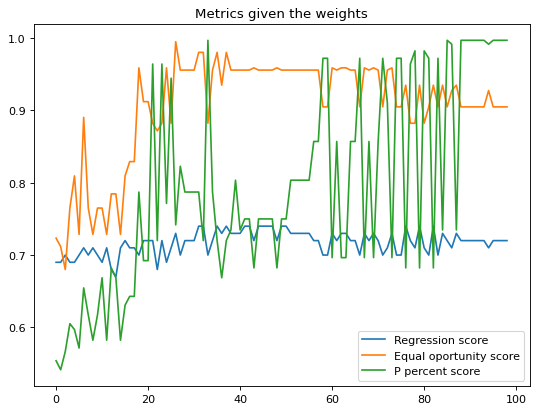

In [26]:
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(metrics['Regression score'], label = "Regression score")
plt.plot(metrics['Equal oportunity score'], label = "Equal oportunity score")
plt.plot(metrics['P percent score'], label = "P percent score")

plt.title('Metrics given the weights')
plt.legend()
plt.show()

In [27]:
print("best_weight: ", best_weight)
print('reg_score: ', weight_reg_score)
print('equal_opportunity_score: ',weight_equal_op_score)
print('p_percent_score: ', weight_p_perc_score)

best_weight:  {0: 0.27, 1: 0.73}
reg_score:  0.73
equal_opportunity_score:  0.9951219512195122
p_percent_score:  0.7417582417582418


## Parte 2: Outros modelos de Fairness

### Modelo 1: Reweighing

Sendo $D$ o dataset, $S$ um atributo sensível, $b \in dom(S)$ e $C$ um classificador, é definida a discriminação do classificador como:

$$disc_{S=b}(C),D := \frac{|\{X\in D|X(S)=w,C(X)=+\}|}{|\{X \in D|X(S)=w\}|}-\frac{|\{X\in D|X(S)=b,C(X)=+\}|}{|\{X \in D|X(S)=b\}|}$$

Assim, calcula-se os pesos:

$$W(s,c) := \frac{|\{X \in D|X(Class)=c\}|\times |\{X \in D| X(S)=s\}|}{|D|\times |\{X \in D|X(Class)=c \text{ and } X(S)=s\}|}$$

E então cria-se um novo dataset $D_W$, que contém o peso $W$ para cada dado do dataset original $D$:

$$D_W := \{(X, W(X(S),X(Class))| X\in D\}$$

Utiliza-se $W$ no treinamento.

In [28]:
def calc_W(X):
  W = {}
  W[0] = {}
  W[1] = {}

  D = len(X)
  len_men = X.groupby('Sex').count()['Age'][0]
  len_women = X.groupby('Sex').count()['Age'][1]
  len_neg = X.groupby("Risk").count()['Age'][-1]
  len_pos = X.groupby("Risk").count()['Age'][1]
  len_men_pos = len(X[(X.Sex == 0) & (X.Risk == 1)])
  len_men_neg = len(X[(X.Sex == 0) & (X.Risk == -1)])
  len_women_pos = len(X[(X.Sex == 1) & (X.Risk == 1)])
  len_women_neg = len(X[(X.Sex == 1) & (X.Risk == -1)])

  W[0][1] = (len_men*len_pos)/(D*len_men_pos)
  W[0][-1] = (len_men*len_neg)/(D*len_men_neg)

  W[1][1] = (len_women*len_pos)/(D*len_women_pos)
  W[1][-1] = (len_women*len_neg)/(D*len_women_neg)

  return W

In [29]:
W = calc_W(numerical_data.iloc[100:, :])
W

{0: {-1: 1.0284730450236967, 1: 0.9763340924478365},
 1: {-1: 0.9471804382169104, 1: 1.0513316868032843}}

In [30]:
def ReweightedLogisticRegression(D):
  # Find weights W
  W = calc_W(D)

  # Separate data into X and y
  X = D.drop(['Risk'], axis=1)
  y = D["Risk"]

  # 
  sample_weight = []
  for index, row in D.iterrows():
    sample_weight.append(W[row['Sex']][row['Risk']])


  # Runs regression
  reg = LogisticRegression(max_iter=1000).fit(X, y, sample_weight=sample_weight)

  # Get scores
  reg_score =  reg.score(X_test,y_test)
  print('reg_score: ', reg_score)

  equal_op_score = equal_opportunity_score(sensitive_column="Sex")(reg, X_test, y_test)
  print('equal_opportunity_score: ', equal_op_score)

  p_perc_score = p_percent_score(sensitive_column="Sex")(reg, X_test)
  print('p_percent_score: ', p_perc_score)

  return reg, reg_score, equal_op_score, p_perc_score

In [31]:
reg, reweighing_reg_score, reweighing_equal_op_score, reweighing_p_perc_score = ReweightedLogisticRegression(numerical_data.iloc[100:, :])

reg_score:  0.69
equal_opportunity_score:  0.8823529411764705
p_percent_score:  0.9527777777777778


No handles with labels found to put in legend.


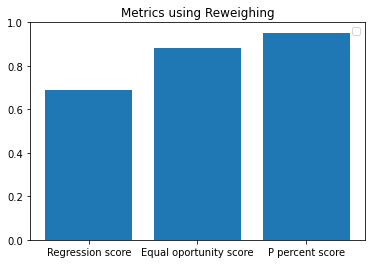

In [32]:
plt.bar(["Regression score", "Equal oportunity score", "P percent score"],[reweighing_reg_score, reweighing_equal_op_score, reweighing_p_perc_score])

plt.title('Metrics using Reweighing')
plt.legend()
plt.show()

### Modelo 2: Information Filter

In [33]:
from sklego.preprocessing import InformationFilter

X_fair = InformationFilter(["Sex"]).fit_transform(X_train)
X_fair = pd.DataFrame(X_fair,
                      columns=[n for n in X_train.columns if n not in ['Sex']])

In [34]:
X_fair

,Age,Job,Housing,Saving accounts,Checking account,Credit amount,Duration
0,41.944386,1.943250,2.910668,1.081587,1.129681,2577.046617,12.106121
1,51.856159,1.998101,3.042991,2.760252,1.174084,338.157621,6.143225
2,64.750459,1.990371,2.979794,1.091956,1.200298,571.147778,21.080368
3,30.121302,2.835255,2.976176,1.091737,2.003100,4454.955133,35.917999
4,36.007168,1.978615,2.919715,1.064381,1.966786,884.092613,18.064552
...,...,...,...,...,...,...,...
417,47.882825,1.184161,2.910432,1.039008,1.926292,1743.070281,24.016088
418,30.121020,2.781778,2.969550,1.101739,1.205314,3958.970879,35.909267
419,40.020620,2.795891,2.980203,1.109352,1.202686,3856.994998,29.974040
420,23.010460,1.874648,1.164030,0.950766,1.075419,1844.984504,44.741960


In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def simple_mod():
    return Pipeline([("scale", StandardScaler()), ("mod", LogisticRegression())])

fair_mod = simple_mod().fit(X_fair, y_train)
fair_pred = fair_mod.predict(X_fair)

In [36]:
fair_mod.score(X_fair, y_train)

0.6279620853080569

### Modelo 3: DemographicParityClassifier

$$\min -\sum_{i=1}^{N} \log p(y_i|x_i, \theta)$$
$$\text{subject to } \frac{1}{N}\sum^N_{i=1}(z_i−z)d_θ(x_i)≤c$$
$$\frac{1}{N}\sum^N_{i=1}(z_i−z)d_θ(x_i)≥−c$$

In [37]:
from sklego.linear_model import DemographicParityClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV

fair_classifier = DemographicParityClassifier(sensitive_cols="Sex", covariance_threshold=0.5)
fair_classifier.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [38]:
demographic_reg_score =  fair_classifier.score(X_test,y_test)
print('reg_score: ', demographic_reg_score)

demographic_equal_op_score = equal_opportunity_score(sensitive_column="Sex")(fair_classifier, X_test, y_test)
print('equal_opportunity_score: ', demographic_equal_op_score)

demographic_p_perc_score = p_percent_score(sensitive_column="Sex")(fair_classifier, X_test)
print('p_percent_score: ', demographic_p_perc_score)

reg_score:  0.72
equal_opportunity_score:  0.9558823529411764
p_percent_score:  0.9300911854103343


No handles with labels found to put in legend.


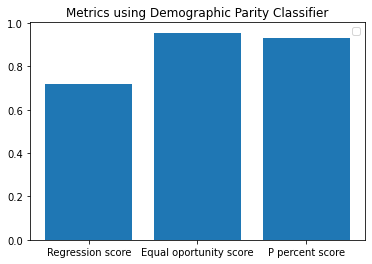

In [39]:
plt.bar(["Regression score", "Equal oportunity score", "P percent score"],[demographic_reg_score, demographic_equal_op_score, demographic_p_perc_score])

plt.title('Metrics using Demographic Parity Classifier')
plt.legend()
plt.show()

### Modelo 4: Equal opportunity classifier

$$\min -\sum_{i=1}^{N} \log p(y_i|x_i, \theta)$$
$$\text{subject to } \frac{1}{POS}\sum^{POS}_{i=1}(z_i−z)d_θ(x_i)≤c$$
$$\frac{1}{POS}\sum^{POS}_{i=1}(z_i−z)d_θ(x_i)≥−c$$

onde $POS$ é o subset da população onde $y\_true = positive\_target$.

In [40]:
import warnings
from sklego.linear_model import EqualOpportunityClassifier
import numpy as np


fair_classifier = GridSearchCV(
    estimator=EqualOpportunityClassifier(
        sensitive_cols="Sex",
        covariance_threshold=0.5,
        positive_target=True,
    ),
    param_grid={"estimator__covariance_threshold": np.linspace(0.001, 1.00, 20)},
    cv=5,
    n_jobs=-1,
    refit="accuracy_score",
    return_train_score=True,
    scoring={"p_percent_score": p_percent_score('Sex'),
            "equal_opportunity_score": equal_opportunity_score('Sex'),
            "accuracy_score": make_scorer(accuracy_score)}
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fair_classifier.fit(X_train, y_train);

In [41]:
oportunity_reg_score =  fair_classifier.score(X_test,y_test)
print('reg_score: ', reg_score)

oportunity_equal_op_score = equal_opportunity_score(sensitive_column="Sex")(fair_classifier, X_test, y_test)
print('equal_opportunity_score: ', equal_op_score)

oportunity_p_perc_score = p_percent_score(sensitive_column="Sex")(fair_classifier, X_test)
print('p_percent_score: ', p_perc_score)

reg_score:  0.72
equal_opportunity_score:  0.9049773755656109
p_percent_score:  0.9970845481049563


No handles with labels found to put in legend.


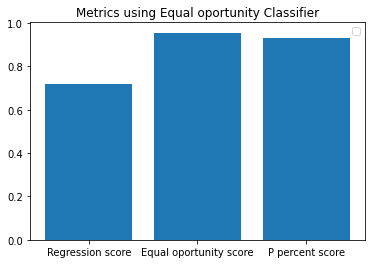

In [42]:
plt.bar(["Regression score", "Equal oportunity score", "P percent score"],[oportunity_reg_score, oportunity_equal_op_score, oportunity_p_perc_score])

plt.title('Metrics using Equal oportunity Classifier')
plt.legend()
plt.show()

## Comparação entre os modelos

In [43]:
r = [[weight_reg_score, weight_equal_op_score, weight_p_perc_score],
     [reweighing_reg_score, reweighing_equal_op_score, reweighing_p_perc_score],
     [demographic_reg_score, demographic_equal_op_score, demographic_p_perc_score],
     [oportunity_reg_score, oportunity_equal_op_score, oportunity_p_perc_score]]

Metrics_models = pd.DataFrame(data=r, columns=["Regression score", "Equal oportunity score", 'P percent score'],
                              index=["Our sample_weight","Reweighing", "Demographic parity classifier", "Equal oportunity classifier"])

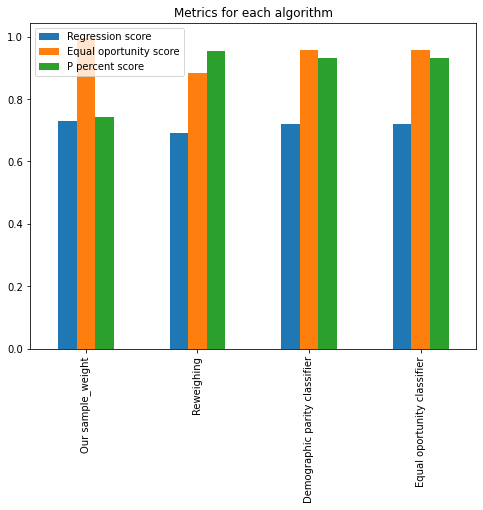

In [44]:
Metrics_models.plot.bar(figsize=(8,6))
plt.title("Metrics for each algorithm")
plt.show()

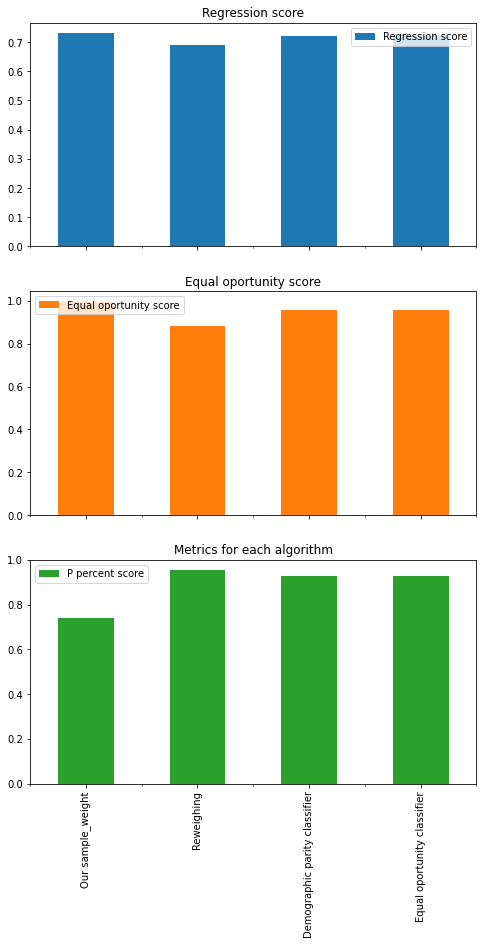

In [45]:
Metrics_models.plot.bar(figsize=(8,14), subplots=True)
plt.title("Metrics for each algorithm")
plt.show()

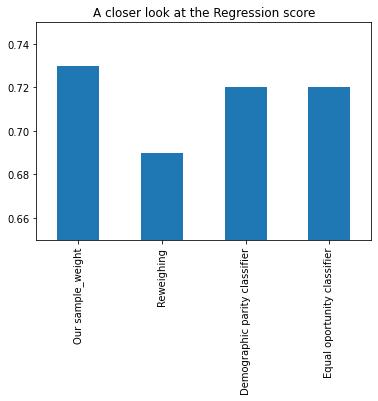

In [46]:
ax1 = Metrics_models["Regression score"].plot.bar()

ax1.set_ylim(0.65, 0.75)
plt.title("A closer look at the Regression score")
plt.show()

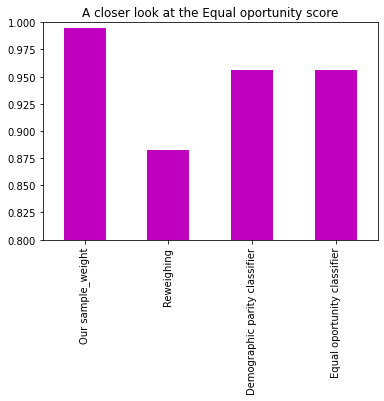

In [47]:
ax1 = Metrics_models["Equal oportunity score"].plot.bar(color='m')

ax1.set_ylim(0.8, 1)
plt.title("A closer look at the Equal oportunity score")
plt.show()

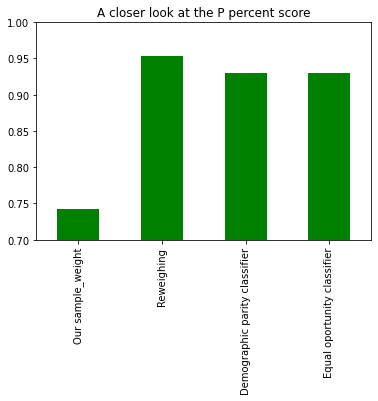

In [48]:
ax1 = Metrics_models["P percent score"].plot.bar(color='g')

ax1.set_ylim(0.7, 1)
plt.title("A closer look at the P percent score")
plt.show()